# ADS Thesis Project - Boosting Models

**Authors: Marion Späth (2772981)**


This notebook documents the Boosting Models for both cattle and goat herders.
The datasets have been created in the R file for the Elastic Net.

In [9]:
#!pip install shap
#! pip install catboost
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import shap

import os

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from catboost import CatBoostRegressor, Pool

# with pickle we can save the model, helps with long computation times
import pickle

### Import datasets

In [5]:
pd.set_option('display.max_columns', None) # show all columns in output

# set working directory
os.chdir('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data')

# load train and test data (previously created in the ElasticNet notebook)
train_cattle = pd.read_csv("train_goat_df.csv")
train_goat = pd.read_csv("train_cattle_df.csv")
test_cattle = pd.read_csv("test_goat_df.csv")
test_goat = pd.read_csv("test_cattle_df.csv")
test_goat.head(2)

,afm_language,age_constant_z,agric_land,amh_language,educ_recoded_constant,eng_language,expend,irrigated_land_bin,number_minors_z,educ_child_recoded,activity_child_recoded,household_description,number_adults_z,main_info_source_recoded,religion_recoded,owns_phone,household_moved,why_not_purchase_recoded,know_vip,trust_vip,resid_mixed
0,No,-0.496108,Yes,No,Never attended,No,0,0,-0.159894,Elementary,Student,Fully settled: The whole of the household (all...,-0.213343,Interpersonal Sources,Traditional/Wakefata,0,No,"Financial, Practical, and Situational Constraints",Yes,Yes,-0.597265
1,No,0.105843,Yes,No,Never attended,No,0,1,-1.389756,Never attended school,Working with Livestock,Fully settled: The whole of the household (all...,1.286942,Interpersonal Sources,Traditional/Wakefata,0,No,"Financial, Practical, and Situational Constraints",Yes,Yes,0.254622


In [ ]:
# Prepare X and Y training sets for models
X_cattle = train_cattle.copy
X_cattle = train_cattle.drop("resid_mixed", axis=1)
X_goat = train_goat.copy
X_goat = train_goat.drop("resid_mixed", axis=1)

Y_cattle = train_cattle["resid_mixed"]
Y_goat = train_goat["resid_mixed"]

# Prepare X and Y training sets for models
X_cattle_TEST = test_cattle.copy
X_cattle_TEST = test_cattle.drop(["resid_mixed", "pred", "residual"], axis=1)

Y_cattle_TEST = test_cattle["resid_mixed"]

In [ ]:
# STEP 2: Specify categorical variables 
cat_features = ['afm_language', 'age_constant_z', 'agric_land', 'amh_language', 'educ_recoded_constant', 'eng_language', 'expend', 'irrigated_land_bin',
                'educ_child_recoded', 'activity_child_recoded', 'household_description', 'main_info_source_recoded', 'religion_recoded', 'owns_phone', 'household_moved',
                'why_not_purchase_recoded', 'know_vip', 'trust_vip'] 


# Ensure categorical columns are string/categorical for compatibility
for col in cat_features:
    X_cattle[col] = X_cattle[col].astype('str')

for col in cat_features:
    X_cattle_TEST[col] = X_cattle_TEST[col].astype('str')

# Instantiate CatBoost Model
catboost_model = CatBoostRegressor(silent=True, random_seed=42)

# Define Hyperparameter Grid
param_grid = {
    'iterations': [30,50,80],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'depth': [-1, 5, 10],
}

# Define custom MAE scorer (scikit-learn expects maximization)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Deinfe 10 Fold Cross-Validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Use RandomizedSearchCV, fit on MAE
search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_grid,
    n_iter=50,
    scoring={'mae': mae_scorer, 'r2': 'r2', 'mse': 'neg_mean_squared_error'},
    refit='mae',  # Refit the best model based on MAE
    cv=cv,
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)

In [ ]:
%%time
# STEP 7: Fit using CV and categorical info
search.fit(X_cattle, Y_cattle, cat_features=cat_features)

c:\anaconda_custom\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 36 candidates, totalling 360 fits


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=<catboost.core.CatBoostRegressor object at 0x000001A65E663EF0>,
                   n_iter=50, n_jobs=-1,
                   param_distributions={'depth': [1, 5, 10, 15],
                                        'iterations': [30, 50, 100],
                                        'learning_rate': [0.01, 0.05, 0.1]},
                   refit='mae', return_train_score=True,
                   scoring={'mae': make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'),
                            'mse': 'neg_mean_squared_error', 'r2': 'r2'},
                   verbose=1)

### Save Model

In [ ]:
# Pickle the model
#with open('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/'+'CATBOOST_cv_model_CATTLE.pickle', 'wb') as to_write:
#    pickle.dump(search, to_write)


In [ ]:
# Read in pickled model
with open('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/' + 'CATBOOST_cv_model_CATTLE.pickle', 'rb') as to_read:
    rf_cv = pickle.load(to_read)

In [ ]:
# Extract best parameters and score
print("Best parameters:", search.best_params_)
print("Best MAE (CV):", -search.best_score_)  # Negative because of sklearn scoring convention

Best parameters: {'learning_rate': 0.1, 'iterations': 50, 'depth': 5}
Best MAE (CV): 1.0395224490071875


### Make Predictions and Calculate Performance Metrics

In [ ]:
# Make Prediction
best_model = search.best_estimator_
y_pred = best_model.predict(X_cattle_TEST)

rmse = np.sqrt(mean_squared_error(Y_cattle_TEST, y_pred))
mae = mean_absolute_error(Y_cattle_TEST, y_pred)
r2 = r2_score(Y_cattle_TEST, y_pred)

print(f"CatBoost Performance on Test Set:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

CatBoost Performance on Test Set:
RMSE: 1.3886
MAE:  1.0450
R²:   0.0048


### Inspect Distribution of Residuals

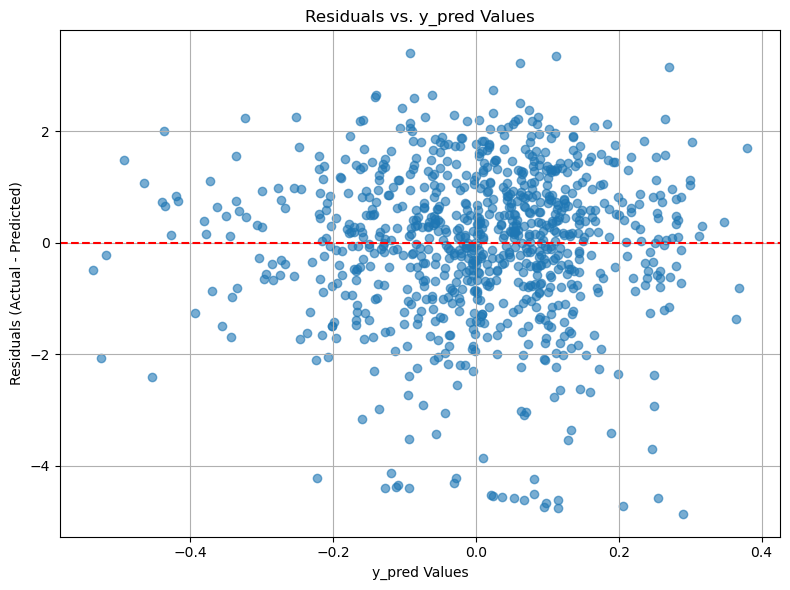

In [ ]:
# Residuals = actual - predicted
residuals = Y_cattle_TEST - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')

plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs. Predicted Values")
plt.grid(True)
plt.tight_layout()
plt.show()


Better than Random Forest, but still pretty centered around 0!